#XLNet4Rec - Amazon Beauty Ratings

#### References: 
<br> 1) Tokenization and embedding
* https://medium.com/huggingface/how-to-build-a-state-of-the-art-conversational-ai-with-transfer-learning-2d818ac26313
* https://reyfarhan.com/posts/easy-gpt2-finetuning-huggingface/

<br> 2) Training and Testing
* https://mccormickml.com/2019/09/19/XLNet-fine-tuning/
* https://towardsdatascience.com/teaching-gpt-2-a-sense-of-humor-fine-tuning-large-transformer-models-on-a-single-gpu-in-pytorch-59e8cec40912
* https://huggingface.co/transformers/model_doc/xlnet.html

<br> 3) Evaluation
* https://github.com/FeiSun/BERT4Rec

# Setup

In [ ]:
# Install transformers
!pip install transformers

     |████████████████████████████████| 1.4MB 8.4MB/s 
     |████████████████████████████████| 2.9MB 29.7MB/s 
     |████████████████████████████████| 890kB 56.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=53c8f40e202c08f2583e714e29a3a4367813de87347db8c8dcd7ae55dd80befb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# Import libraries
import os
import io
import pickle
import time
import datetime
import random
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

import sklearn
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)
from tqdm import tqdm, trange

from transformers import BertTokenizer, XLNetTokenizer, XLNetConfig, XLNetModel, XLNetLMHeadModel 
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
excelfile = F"/content/gdrive/My Drive/ratings_Beauty.csv"

In [ ]:
# Visualize dataset
amazon_ratings = pd.read_csv(excelfile)
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [ ]:
# Find users with more than 5 ratings
idlist = amazon_ratings['UserId'].value_counts()
indexes = idlist[idlist >= 5].index

In [ ]:
# Extract Popular items
pdlist = amazon_ratings['ProductId'].value_counts()

In [ ]:
# Combine users and ratings as a list
ratings_subset = amazon_ratings[amazon_ratings['UserId'].isin(indexes)]
ratings_subset.sort_values(by=['UserId', 'Timestamp'], inplace = True)
ratings_final = ratings_subset.groupby('UserId')['ProductId'].apply(list).reset_index(name='items')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


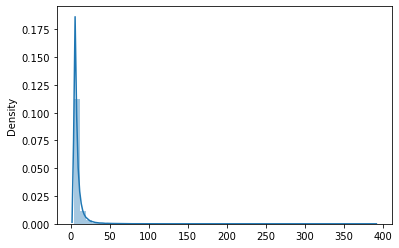

In [ ]:
# Check length of items per user
import seaborn as sns

item_lengths = []

for r in range(0,len(ratings_final['items'])):

    # get rough token count distribution
    item_lengths.append(len(ratings_final['items'][r]))

doc_lengths = np.array(item_lengths)

sns.distplot(item_lengths)

In [ ]:
# Maximum length of items
np.max(item_lengths)

389

In [ ]:
# Median length of items
np.mean(item_lengths)

8.96954595791805

In [ ]:
# Viusalize final dataset
ratings_final.head()

,UserId,items
0,A00414041RD0BXM6WK0GX,"[B007IY97U0, B00870XLDS, B008MIRO88, B00BQYYMN..."
1,A00473363TJ8YSZ3YAGG9,"[B000FABN7E, B0019LVFI0, B00AE07JIM, B0020HEBX..."
2,A00700212KB3K0MVESPIY,"[B001MP0T2Q, B001RMP7M6, B003TMO3EU, B00028M3N..."
3,A00728291XHL0K3ETGQOG,"[B007Y7WL4A, B008FX4LO0, B009Q1YPVY, B003JM0YP..."
4,A0078719IR14X3NNUG0F,"[B006L1DNWY, B008RRX9CE, B0069FDR96, B00BNB38A..."


In [ ]:
# Length of final dataset
len(ratings_final)

52374

In [ ]:
# Create new tokens
from itertools import chain
#new_tokens = list(set(list(chain(*ratings_final['items']))))
new_tokens = list(pdlist.index)[0:54541]
#new_tokens = ['<unk>','<s>','</s>','<cls>','<sep>','<pad>','<mask>','<eod>','<eop>'] + new_tokens
new_tokens = ['<unk>','<mask>','<pad>','<cls>','<sep>'] + new_tokens

In [ ]:
# Length of new tokens
len(new_tokens)

54546

In [ ]:
# Create vocab list for tokenizer
with open('vocab.txt', 'w') as f:
    for item in new_tokens:
        f.write("%s\n" % item)

# Dataset Preparation

In [ ]:
# Tokenizer
tokenizer = BertTokenizer(vocab_file='vocab.txt', unk_token='<unk>', do_lower_case=False)

In [ ]:
#tokenizer2 = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

In [ ]:
#tokenizer2.convert_tokens_to_ids('<pad>')

In [ ]:
# Padding function
max_length=50
# Now we can pad reply and distractor inputs and targets to the same length
def pad(x, padding):
    return x + [padding] * (max_length - len(x))

In [ ]:
# Prepare item seq and padding function
item_seq = ratings_final['items']
train = []
val = []
test = []

for i in range(0,len(item_seq)):
  if len(item_seq[i]) > max_length:
    seq = item_seq[i][0:max_length]
  else:
    seq = item_seq[i]
  train.append(seq[0:-2])
  val.append(seq[0:-1])
  test.append(seq)

In [ ]:
'''
# Testing
seq = item_seq[0]
tokens = seq + ['<sep>'] + ['<cls>'] 

# words token
input_words = tokenizer.convert_tokens_to_ids(tokens)
input_words = pad(input_words, 5)
words = torch.tensor(input_words, dtype=torch.long)
assert len(words) == max_length
print(words)

# lables
lables = words[torch.where(words == 4)[0]-1]
#self.labels.append(labels)
print(lables)
    
# perm_mask
perm_mask = torch.zeros((1, words.shape[0], words.shape[0]), dtype=torch.long)
perm_mask[:, :, torch.where(words == 4)[0]-1] = 1
#self.perm_mask.append(perm_mask)
print(perm_mask[0])

# target mapping
target_mapping = torch.zeros((1, 1, words.shape[0]), dtype=torch.long)
target_mapping[0, 0, torch.where(words == 4)[0]-1] = 1
#self.perm_mask.append(target_mapping)
print(target_mapping)

# masking
words[torch.where(words == 4)[0]-1] = 1
#self.input_ids.append(words)
print(words)
'''

"\n# Testing\nseq = item_seq[0]\ntokens = seq + ['<sep>'] + ['<cls>'] \n\n# words token\ninput_words = tokenizer.convert_tokens_to_ids(tokens)\ninput_words = pad(input_words, 5)\nwords = torch.tensor(input_words, dtype=torch.long)\nassert len(words) == max_length\nprint(words)\n\n# lables\nlables = words[torch.where(words == 4)[0]-1]\n#self.labels.append(labels)\nprint(lables)\n    \n# perm_mask\nperm_mask = torch.zeros((1, words.shape[0], words.shape[0]), dtype=torch.long)\nperm_mask[:, :, torch.where(words == 4)[0]-1] = 1\n#self.perm_mask.append(perm_mask)\nprint(perm_mask[0])\n\n# target mapping\ntarget_mapping = torch.zeros((1, 1, words.shape[0]), dtype=torch.long)\ntarget_mapping[0, 0, torch.where(words == 4)[0]-1] = 1\n#self.perm_mask.append(target_mapping)\nprint(target_mapping)\n\n# masking\nwords[torch.where(words == 4)[0]-1] = 1\n#self.input_ids.append(words)\nprint(words)\n"

In [ ]:
# Class for creating dataset
class XLNetDataset(Dataset):

  def __init__(self, item_seq, tokenizer, max_length=50):
    self.tokenizer = tokenizer
    self.input_ids = []
    self.lables = []
    #self.perm_mask = []
    self.target_mapping = []
    
    for seq in item_seq: 
      if len(seq) == max_length:
        seq = seq[0:-2]
      elif len(seq) == (max_length-1):
        seq = seq[0:-1]
      else:
        seq = seq
      tokens = seq + ['<sep>'] + ['<cls>'] 

      # words token
      input_words = tokenizer.convert_tokens_to_ids(tokens)
      input_words = pad(input_words, 2)
      words = torch.tensor(input_words, dtype=torch.long)
      assert len(words) == max_length

      # lables
      lables = words[torch.where(words == 4)[0]-1]
      self.lables.append(lables)

      '''
      # perm_mask
      perm_mask = torch.zeros((1, words.shape[0], words.shape[0]), dtype=torch.long)
      perm_mask[:, :, torch.where(words == 4)[0]-1] = 1
      self.perm_mask.append(perm_mask[0])
      '''
      # target mapping
      target_mapping = torch.zeros((1, 1, words.shape[0]), dtype=torch.float)
      target_mapping[0, 0, torch.where(words == 4)[0]-1] = 1
      self.target_mapping.append(target_mapping[0])

      # masking
      words[torch.where(words == 4)[0]-1] = 1
      self.input_ids.append(words)

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.lables[idx], self.target_mapping[idx], #self.perm_mask[idx], 

In [ ]:
# Create Dataset
#dataset = XLNetDataset(item_seq, tokenizer, max_length=50)
train_dataset = XLNetDataset(train, tokenizer, max_length=50)
val_dataset = XLNetDataset(val, tokenizer, max_length=50)
test_dataset = XLNetDataset(test, tokenizer, max_length=50)

# Reference

In [ ]:
'''
# Sample
tokenizer2 = XLNetTokenizer.from_pretrained('xlnet-large-cased')
model2 = XLNetLMHeadModel.from_pretrained('xlnet-large-cased', return_dict=True)
'''

In [ ]:
'''
input_ids = torch.tensor(tokenizer2.encode("Hello, my dog is very <mask>", add_special_tokens=False)).unsqueeze(0)  # We will predict the masked token
input_ids
#outputs = model(input_ids, perm_mask=perm_mask, target_mapping=target_mapping)
#next_token_logits = outputs[0]  # Output has shape [target_mapping.size(0), target_mapping.size(1), config.vocab_size]
'''

tensor([[   17, 11368,    19,    94,  2288,    27,   172,     6]])

In [ ]:
#torch.tensor(tokenizer2.encode("cute", add_special_tokens=False)).unsqueeze(0)

tensor([[10920]])

In [ ]:
#labels = torch.tensor(tokenizer2.encode("cute", add_special_tokens=False)).unsqueeze(0)
#labels

tensor([[10920]])

In [ ]:
'''
perm_mask = torch.zeros((1, input_ids.shape[1], input_ids.shape[1]), dtype=torch.float)
perm_mask[:, :, -1] = 1.0  # Previous tokens don't see last token
perm_mask
'''

tensor([[[0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 0., 0., 1.]]])

In [ ]:
'''
target_mapping = torch.zeros((1, 1, input_ids.shape[1]), dtype=torch.float)  # Shape [1, 1, seq_length] => let's predict one token
target_mapping[0, 0, -1] = 1.0  # Our first (and only) prediction will be the last token of the sequence (the masked token)
target_mapping
'''

tensor([[[0., 0., 0., 0., 0., 0., 0., 1.]]])

In [ ]:
'''
outputs = model2(input_ids, perm_mask=perm_mask, target_mapping=target_mapping)
print(outputs)  # Output has shape [target_mapping.size(0), target_mapping.size(1), config.vocab_size]
'''

# Training

In [ ]:
batch_size = 2

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = SequentialSampler(train_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = 1 # Evaluate with this batch size.
        )

# Test
test_dataloader = DataLoader(
            test_dataset, # The test samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'

In [ ]:
config = XLNetConfig(
    vocab_size=54546
)

In [ ]:
model = XLNetLMHeadModel(config=config)

In [ ]:
'''
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]
'''

In [ ]:
'''
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)
'''

In [ ]:
BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-4
WARMUP_STEPS = 100
MAX_SEQ_LEN = 50
total_steps = len(train_dataloader) * EPOCHS

In [ ]:
'''
# Testing
model = model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps ,last_epoch = -1)

for step, batch in enumerate(train_dataloader):
  b_input_ids = batch[0].to(device)
  b_labels = batch[1].to(device)
  b_target_mapping = batch[2].to(device)
  # Clear out the gradients (by default they accumulate)
  optimizer.zero_grad()
  # Forward pass
  outputs = model(input_ids=b_input_ids, labels=b_labels, target_mapping=b_target_mapping)
  loss = outputs[0]
  logits = outputs[1]
  loss.backward()
  optimizer.step()
  print(loss)
  print(logits)
  #model.zero_grad()
  if step == 10:
    break
'''

In [ ]:
%%time
model = model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps ,last_epoch = -1)
proc_seq_count = 0
sum_loss = 0.0
batch_count = 0

models_folder = "trained_models"
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

for epoch in range(EPOCHS):
    
    print(f"EPOCH {epoch} started" + '=' * 30)
    
    for idx, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_target_mapping = batch[2].to(device)
        
        outputs = model(input_ids=b_input_ids, labels=b_labels, target_mapping=b_target_mapping)

        loss, logits = outputs[:2]                        
        loss.backward()
        sum_loss = sum_loss + loss.detach().data
                       
        proc_seq_count = proc_seq_count + 1
        if proc_seq_count == BATCH_SIZE:
            proc_seq_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()

        if batch_count == 100:
            print(f"sum loss {sum_loss}")
            batch_count = 0
            sum_loss = 0.0
    
    # Store the model after each epoch to compare the performance of them
    torch.save(model.state_dict(), os.path.join(models_folder, f"XLNet4Rec_{epoch}.pt"))

EPOCH 0 started==============================
sum loss 1922.1448974609375
sum loss 1883.1368408203125
sum loss 1839.5030517578125
sum loss 1922.7640380859375
sum loss 1940.249267578125
sum loss 1871.23193359375
sum loss 1960.0362548828125
sum loss 1886.475830078125
sum loss 1905.7127685546875
sum loss 1898.388671875
sum loss 1864.1259765625
sum loss 1927.08642578125
sum loss 1908.98388671875
sum loss 1867.8594970703125
sum loss 1920.5791015625
sum loss 1962.9193115234375
sum loss 1895.4705810546875
sum loss 1905.1766357421875
sum loss 1815.031982421875
sum loss 1915.73779296875
sum loss 1930.24267578125
sum loss 1916.1710205078125
sum loss 1859.7236328125
sum loss 1822.3399658203125
sum loss 1866.4078369140625
sum loss 1933.278076171875
sum loss 1892.3060302734375
sum loss 1953.1534423828125
sum loss 1935.8675537109375
sum loss 1919.7156982421875
sum loss 1951.60791015625
sum loss 1964.863037109375
sum loss 1919.988037109375
sum loss 1978.4381103515625
sum loss 2002.5152587890625
sum l

In [ ]:
model_save_name = 'XLNet4Rec_Amazon_1.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

# Another Training

In [ ]:
model_save_name = 'XLNet4Rec_Amazon_4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
%%time
# Train one more epoch
model = model.to(device)
model.train()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=total_steps ,last_epoch = -1)
proc_seq_count = 0
sum_loss = 0.0
batch_count = 0

models_folder = "trained_models"
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

for epoch in range(EPOCHS):
    
    print(f"EPOCH {epoch} started" + '=' * 30)
    
    for idx, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_labels = batch[1].to(device)
        b_target_mapping = batch[2].to(device)
        
        outputs = model(input_ids=b_input_ids, labels=b_labels, target_mapping=b_target_mapping)

        loss, logits = outputs[:2]                        
        loss.backward()
        sum_loss = sum_loss + loss.detach().data
                       
        proc_seq_count = proc_seq_count + 1
        if proc_seq_count == BATCH_SIZE:
            proc_seq_count = 0    
            batch_count += 1
            optimizer.step()
            scheduler.step() 
            optimizer.zero_grad()
            model.zero_grad()

        if batch_count == 100:
            print(f"sum loss {sum_loss}")
            batch_count = 0
            sum_loss = 0.0
    
    # Store the model after each epoch to compare the performance of them
    torch.save(model.state_dict(), os.path.join(models_folder, f"XLNet4Rec_{epoch}.pt"))

EPOCH 0 started==============================
sum loss 1523.27197265625
sum loss 1454.9598388671875
sum loss 1460.3375244140625
sum loss 1492.487060546875
sum loss 1580.1248779296875
sum loss 1498.4080810546875
sum loss 1591.8331298828125
sum loss 1551.698974609375
sum loss 1647.8756103515625
sum loss 1574.5560302734375
sum loss 1553.2171630859375
sum loss 1667.1380615234375
sum loss 1680.241943359375
sum loss 1605.65283203125
sum loss 1592.3609619140625
sum loss 1717.9918212890625
sum loss 1644.5399169921875
sum loss 1651.5316162109375
sum loss 1587.42919921875
sum loss 1658.5223388671875
sum loss 1641.979248046875
sum loss 1634.0677490234375
sum loss 1619.27880859375
sum loss 1613.419189453125
sum loss 1600.4117431640625
sum loss 1707.8651123046875
sum loss 1706.2078857421875
sum loss 1673.057861328125
sum loss 1653.172607421875
sum loss 1707.023681640625
sum loss 1679.5775146484375
sum loss 1697.626220703125
sum loss 1702.654052734375
sum loss 1738.0567626953125
sum loss 1734.018798

In [ ]:
model_save_name = 'XLNet4Rec_Amazon_4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)

# Testing

In [ ]:
model_save_name = 'XLNet4Rec_Amazon_4.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
model.load_state_dict(torch.load(path))

In [ ]:
# Top products
vocab_size = 54541
topProducts = [0,1,2,3,4] + tokenizer.convert_tokens_to_ids(list(pdlist.index)[0:vocab_size])

In [ ]:
# Probability of each items
sum_value = np.sum([x for x in pdlist.values[0:vocab_size]])
probs = [0,0,0,0,0,] + [value / sum_value for value in pdlist.values[0:vocab_size]]

In [ ]:
# Negative samples
%%time
np.random.seed(12345)
neg_samples = []
for j in range(0,len(test_dataset)):
  samples = np.random.choice(topProducts, 100, replace=False, p=probs)
  notinTest = [i for i in samples if i not in test_dataset[j][0][0:torch.where(test_dataset[j][0] == 1)[0]].tolist()]
  notinTest = notinTest + test_dataset[j][1].tolist()
  neg_samples.append(notinTest)

CPU times: user 9min 2s, sys: 23.6 s, total: 9min 25s
Wall time: 9min 25s


In [ ]:
# Compute Lengths
neg_samples_length = []
for i in range(0,len(neg_samples)):
  neg_samples_length.append(len(neg_samples[i]))

print(np.min(neg_samples_length))

98


In [ ]:
%%time
# Testing
model = model.to(device)
labels = []
results = []

for idx, batch in enumerate(test_dataloader):
    b_input_ids = batch[0].to(device)
    b_labels = batch[1].to(device)
    b_target_mapping = batch[2].to(device)
    
    with torch.no_grad():
      outputs = model(input_ids=b_input_ids, labels=b_labels, target_mapping=b_target_mapping)
      logits = outputs[1]
    
    softmax_logits = torch.softmax(logits[0],dim=1)
    softmax_logits = softmax_logits.detach().cpu().numpy()

    label_ids = b_labels.to('cpu').numpy()
    labels.append(label_ids[0])

    results.append(softmax_logits)

CPU times: user 24min 7s, sys: 28.1 s, total: 24min 35s
Wall time: 24min 35s


# Evaluation

In [ ]:
# Ranking
%%time
tens = []
fives = []
ones = []

for i in range(0,len(results)):
  top_idx = np.argsort(results[i][0][neg_samples[i]])[-10:]
  top_values = [neg_samples[i][e] for e in top_idx]
  top_values.reverse()
  tens.append(top_values)
  fives.append(top_values[0:5])
  ones.append([top_values[0]])

CPU times: user 622 ms, sys: 16 ms, total: 638 ms
Wall time: 639 ms


In [ ]:
# For HitRate
matched_tens = []
matched_fives = []
matched_ones = []

for i in range(0,len(labels)):
  matched_tens.append(labels[i][0] in tens[i])
  matched_fives.append(labels[i][0] in fives[i])
  matched_ones.append(labels[i][0] in ones[i])

In [ ]:
# For HitRate
matched_tens = []
matched_fives = []
matched_ones = []

for i in range(0,len(labels)):
  matched_tens.append(labels[i][0] in tens[i])
  matched_fives.append(labels[i][0] in fives[i])
  matched_ones.append(labels[i][0] in ones[i])

In [ ]:
# HitRate
print('HR@10:', sum(matched_tens)/len(labels))
print('HR@5:', sum(matched_fives)/len(labels))
print('HR@1:', sum(matched_ones)/len(labels))

HR@10: 0.06201550387596899
HR@5: 0.061175392370260054
HR@1: 0.059647916905334705


In [ ]:
# For NDCG
ndcg_tens = []
ndcg_fives = []
ndcg_ones = []

for i in range(0,len(labels)):
  for j in range(0,len(tens[i])):
    if labels[i] == tens[i][j]:
      ndcg_tens.append(1/np.log2(j+2))
    else:
      ndcg_tens.append(0)
  for j in range(0,len(fives[i])):
    if labels[i] == fives[i][j]:
      ndcg_fives.append(1/np.log2(j+2))
    else:
      ndcg_fives.append(0)
  for j in range(0,len(ones[i])):
    if labels[i] == ones[i][j]:
      ndcg_ones.append(1/np.log2(j+2))
    else:
      ndcg_ones.append(0)

In [ ]:
# NDCG
print('NDCG@10:', np.mean(ndcg_tens))
print('NDCG@5:', np.mean(ndcg_fives))
print('NDCG@1:', np.mean(ndcg_ones))

NDCG@10: 0.006070942010597363
NDCG@5: 0.012087769897673009
NDCG@1: 0.059647916905334705


In [ ]:
# For MRR
rr = []

for i in range(0,len(labels)):
  for j in range(0,len(tens[i])):
    if labels[i] == tens[i][j]:
      rr.append(1/(j+1))
    else:
      rr.append(0)

In [ ]:
# MRR
print('MRR', np.mean(rr)) 

MRR 0.006030680738837457
